# Predire emozioni di una canzone

**Progetto di Programmazione di Applicazioni Data Intensive**   
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

Studente Corrado Stortini   
`corrado.stortini2@studio.unibo.it`

## Setup

- Importare i package necessari

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline

## Introduzione

- L'obbiettivo è quello di classificare le canzoni in base a quale emozioni suscitano negli utenti che le ascoltano
    - 0 -> Triste
    - 1 -> Felice
    - 2 -> Energetica
    - 3 -> Calma
- Il dataset usato è _278k Emotion Labeled Spotify Songs_, reperibile su [_Kaggle_](https://www.kaggle.com/datasets/abdullahorzan/moodify-dataset)
- Il dataset completo è composto da 12 variabili, di cui 1 di target (*label*)


In [3]:
songs = pd.read_csv("278k_song_labelled.csv", index_col="Unnamed: 0")
songs.head(10)

,duration (ms),danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,spec_rate,labels
0,195000.0,0.611,0.614,-8.815,0.0672,0.0169,0.000794,0.7530,0.520,128.050,3.446154e-07,2
1,194641.0,0.638,0.781,-6.848,0.0285,0.0118,0.009530,0.3490,0.250,122.985,1.464234e-07,1
2,217573.0,0.560,0.810,-8.029,0.0872,0.0071,0.000008,0.2410,0.247,170.044,4.007850e-07,1
3,443478.0,0.525,0.699,-4.571,0.0353,0.0178,0.000088,0.0888,0.199,92.011,7.959809e-08,0
4,225862.0,0.367,0.771,-5.863,0.1060,0.3650,0.000001,0.0965,0.163,115.917,4.693131e-07,1
5,166920.0,0.572,0.837,-7.876,0.0367,0.0197,0.000000,0.1630,0.627,100.343,2.198658e-07,1
6,193133.0,0.725,0.687,-6.465,0.0596,0.6940,0.000369,0.2310,0.770,96.005,3.085956e-07,1
7,253000.0,0.675,0.547,-4.999,0.0481,0.1140,0.000080,0.0678,0.365,75.003,1.901186e-07,1
8,216187.0,0.516,0.692,-4.842,0.0279,0.0875,0.009300,0.0900,0.181,83.571,1.290549e-07,0
9,232333.0,0.548,0.509,-7.937,0.0288,0.2610,0.702000,0.0790,0.484,78.974,1.239600e-07,0


## Spiegazione attributi

- *duration (ms)* è la durata in millisecondi della traccia
- *danceability* è un valore compreso tra 0 e 1 che riporta la "danzabilità" di una traccia, valori più alti indicano una traccia più danzabile (potrebbe essere legata alla variabile *tempo*)
- *energy* indica una misura di intensità e attività percepiti. Tipicamente tracce energetiche sono veloci, forti e rumorose, per esempio come la musica Metal
- *loudness* è il volume della traccia audio, i valori vanno da -60 a 0 db. Questi valori sono la media del volume audio di tutta la traccia.
- *speechiness* indica la quantità di parole cantate in una traccia. Più una traccia sarà parlata (per esempio un audiolibro o una poesia) più il valore si avvicinerà ad 1.
- *acousticness* indica il livello di acustica nella traccia. Valori vicini ad 1 indicano un'alta probabilità che la traccia sia acustica.
- *instrumentalness* indica se una traccia non contiene voce. Più il valore è vicino ad 1, più è probabile che la traccia non contenga voce. Valori sopra a 0.5 indicano che potrebbe essere priva di voce, ma più sono alti più è questa probabilità.
- *liveness* è la probabilità che la traccia sia in diretta, in base a quanto si sente la presenza di un pubblico. Valori sopra al 0.8 indicano una altissima probabilità che la traccia sia in diretta.
-  *valence* indica generalmente quanto è positiva una traccia. Valori alti indicano una valenza positiva (felice, gioiosa, euforica) e valori bassi indicano una valenza negativa (triste, arrabiata, depressa)
- *tempo* è la durata media dei battiti in una canzone.
- *spec_rate* è un'informazione generale sulla voce nella traccia (sarà probabilmente legato a *speechiness*)

Non ci sono dati mancanti o errati nel dataset come riportato nelle statistiche sul [sito](https://www.kaggle.com/datasets/abdullahorzan/moodify-dataset)

Un identificativo numerico è utilizzato come indice per le righe

## Esplorazione Dataset

- Come prima cosa da fare, creaiamo train e data set

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    songs.drop(columns=["labels"], axis=1), songs["labels"],
    test_size=1/3,
    random_state=23
)

- Diamo ora un'occhiata a varie statistiche generali nel dataset come media, numero di istanze e così via.

In [5]:
X_train.describe()

,duration (ms),danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,spec_rate
count,1.852920e+05,185292.000000,185292.000000,185292.000000,185292.000000,185292.000000,185292.000000,185292.000000,185292.000000,185292.000000,1.852920e+05
mean,2.326443e+05,0.552738,0.557183,-10.366698,0.087808,0.385841,0.254647,0.189181,0.449714,119.211747,4.736415e-07
std,1.173501e+05,0.188920,0.279628,6.688214,0.112253,0.363994,0.373593,0.163628,0.267415,30.464650,9.181183e-07
min,6.706000e+03,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,1.720930e+05,0.432000,0.342750,-12.745000,0.035900,0.034000,0.000000,0.096200,0.220000,95.067000,1.532238e-07
50%,2.131070e+05,0.571000,0.592000,-8.391000,0.047100,0.262000,0.001060,0.120000,0.434000,119.950000,2.342706e-07
75%,2.649810e+05,0.693000,0.792000,-5.838000,0.082100,0.752000,0.643000,0.227000,0.665000,138.944000,4.435727e-07
max,3.919895e+06,0.989000,1.000000,4.882000,0.965000,0.996000,1.000000,1.000000,1.000000,244.947000,5.971860e-05


- Controlliamo ora quante tracce appartengono ad ogni *labels*

In [7]:
y_train.value_counts()

1    71260
0    54526
2    31248
3    28258
Name: labels, dtype: int64

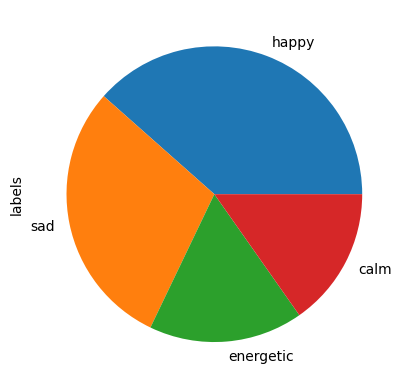

In [24]:
y_train.value_counts().plot.pie(labels=("happy", "sad", "energetic", "calm"));

- Controlliamo ora se dalla *loudness* potrebbero esserci correlazioni più forti con *labels*

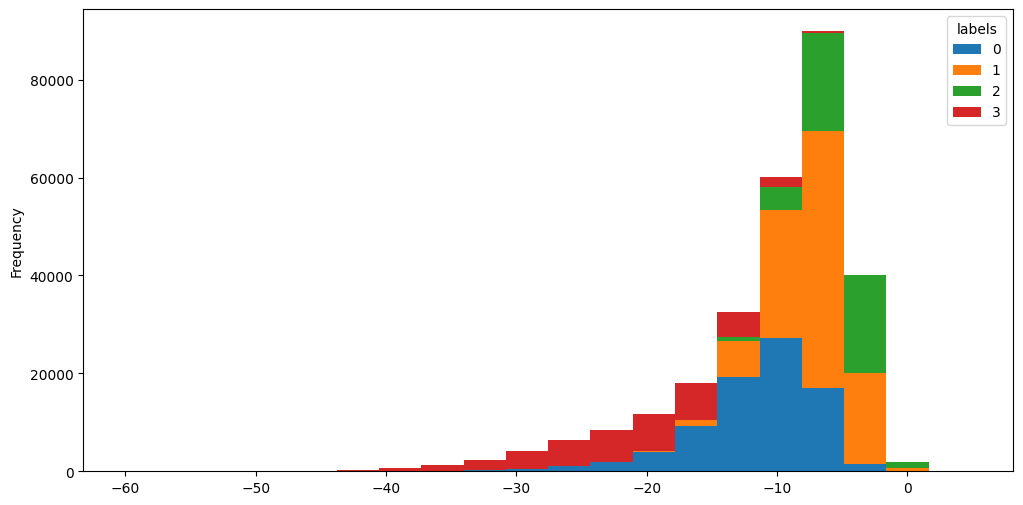

In [47]:
songs.pivot(columns="labels")["loudness"].plot.hist(bins=20, stacked=True, figsize=(12, 6));

- Come si può notare, ad un valore di volume più basso corrispondono tendenzialmente tracce calme, mentre a valori più alti ci sono tracce principalmente felici, energetiche o tristi

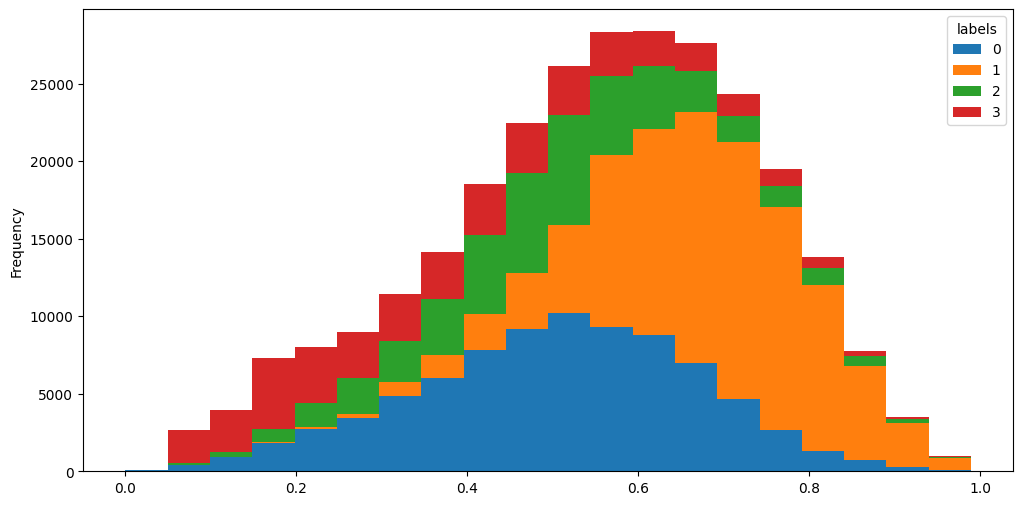

In [48]:
songs.pivot(columns="labels")["danceability"].plot.hist(bins=20, stacked=True, figsize=(12, 6));

- Con questo grafico si può invece notare come a valori di danzabilità bassi corrispondano principalmente tracce tristi o calme, mentre a valori più alti ci sono tracce felici.

**Altre statistiche**

- Se controlliamo quante sono le tracce audio più ballabili, si può intuire che molte delle tracce nel train set sono tracce musicali

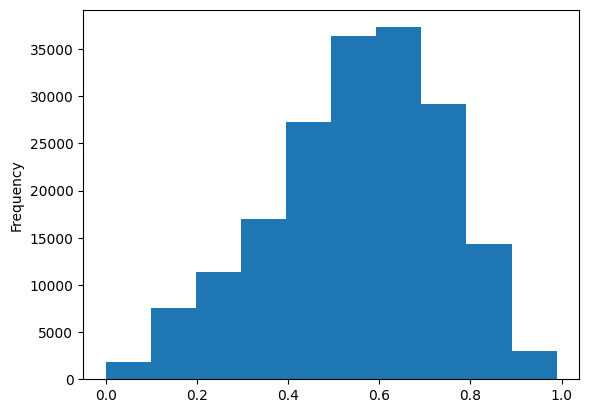

In [134]:
X_train["danceability"].plot.hist();